# Importance Sampling

This is referenced from Professor O.Deniz.Akyildiz's [Advanced Simulation course](https://akyildiz.me/advanced-monte-carlo/Week-1/importance-sampling.html#)

When one wants to evaluate some integral $\int \varphi(x) p(x) dx$ by using Monte Carlo integration, the variance reduction rate is $O(1/N)$.  
Problem is that we may not be directly able to sample from $p$ (we may only have an unnormalized $p$, or we are interested in some tail events, and outright MC has very low acceptance rate)

With IS, we obtain some weighted samples $\{\mathsf{w}_i, X_i\}_{i=1}^N$, where the $X_i$ are samples from some target $q(x)$.  
We can use the sample to evaluate any interested function $\varphi(x)$ with respect to $\pi(x)$:

$$
\int \varphi(x) \pi(x) dx = \int \varphi(x) \frac{\pi(x)}{q(x)} q(x)dx
$$

$$
\approx \frac{1}{N} \sum_{i=1}^{N} \varphi(X_i) \frac{\pi(X_i)}{q(X_i)} 
$$

$$
= \frac{1}{N} \sum_{i=1}^{N} W_i \; \varphi(X_i) = \sum_{i=1}^{N} w_i \; \varphi(X_i)
$$

This typically achieves variance reduction compared with basic MC integration, tho the variance decay rate is still $O(1/N)$



### Tail Events
Consider for example, for $X \sim \mathcal{N}(0, 1)$:
$$
P(X > 4) = \int \mathbb{1}(x >4) p(x) dx
$$
Typical idea is to sample $X_i \sim \mathcal{N}(0, 1)$, and if $X_i > 4$, it is accepted as a sample. In this case, even if we sample $N=10000$, we might still get 0 accpeted samples.

$$
\int \mathbb{1}(x >4) p(x) dx
= \int \mathbb{1}(x >4) \frac{p(x)}{q(x)} q(x) dx
$$

$$
= E_q[\mathbb{1}(x >4)  \frac{p(x)}{q(x)}]
$$

$$
= \frac{1}{N} \sum \mathbb{1}(X_i >4)  \frac{p(X_i)}{q(X_i)}
$$

In this case we can use a propsal $\mathcal{N}(6, 1)$, and weight each sample $X_i$ by $\frac{\mathcal{N}(X_i; 0, 1)}{\mathcal{N}(X_i; 6, 1)}$

An implementation:

In [24]:
import numpy as np

rng = np.random.default_rng(26)
N = 10000
x_samples = rng.normal(6, 1, N)

xx = np.linspace(4, 20, 100000)

def p(x, mu, sigma):
    '''N(x|mu, sigma)'''
    return np.exp(-(x-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

I = np.trapz(p(xx, 0, 1), xx) # Numerical computation of the integral
print('Integral of p(x) from 4 to infinity: ', I)

weights = p(x_samples, 0, 1)/p(x_samples, 6, 1)
IS_est = 1/N * np.sum((x_samples>4)*weights)
print('Importance sampling estimate: ', IS_est)



Integral of p(x) from 4 to infinity:  3.16712429751607e-05
Importance sampling estimate:  3.1925567492155485e-05


### Self-normalizing IS

When we are presented with unnormalized densities, IS won't work. 

Given $\bar{p}(x)$ unnormalized, we don't know the normalizing constant $Z = \int \bar{p}(x) dx$ such that $p = \bar{p}(x) / Z$ can be computed.

We want to compute

$$
\bar{\varphi} = \int \varphi(x) p(x) \,dx,
$$

$$
= \frac{\int \varphi(x) \frac{\bar{p}(x)}{q(x)} q(x) \,dx}{\int \frac{\bar{p}(x)}{q(x)} q(x) \,dx},
$$

i.e. We can do two IS, one for numerator, one for denominator

$$
\hat{\varphi}_{\text{SNIS}}^N = \frac{\frac{1}{N} \sum_{i=1}^{N} \varphi(X_i) W_i}{\frac{1}{N} \sum_{i=1}^{N} W_i},
$$

$$
= \frac{\sum_{i=1}^{N} \varphi(X_i) W_i}{\sum_{i} W_i}
$$

$$
= \sum_{i=1}^{N} \frac{W_i}{\sum_i W_i} \varphi(X_i) = \sum_{i=1}^{N} w_i \varphi(X_i),
$$

Where $W_i = \bar{p}(X_i) / q(X_i) $

Say we want to estimate the mean of some unnormalized $\bar{p}$, using propsal $\mathcal{N}(0, \sigma_{\text{IS}}^2)$:  
The SNIS algo is given by
- Fix $N, \sigma_{IS}$
- Sample $(X_1, \dots X_N) \sim \mathcal{N}(0, \sigma_{\text{IS}}^2)$.
- Compute unnormalised weights $W^{(i)} = \frac{\pi(X_{i})}{q(X_{i})}$.
- Normalize weights $w_i = \frac{W_i}{\sum_{j=1}^{N} W_j}$, 

And we obtain the SNIS estimate of the posterior mean: 

$$
\sum W_i X_i
$$

Consider the banana density, which is a numerically challenging density to integrate:
\begin{align*}
\pi(x) \propto \exp\left(- \frac{x_1^2}{10} - \frac{x_2^2}{10} - 2 (x_2 - x_1^2)^2
\right).
\end{align*}

Since we cannot integrate it, we can't normalize it. 
We first plot the density, and observe that the mean is around (0, 1)

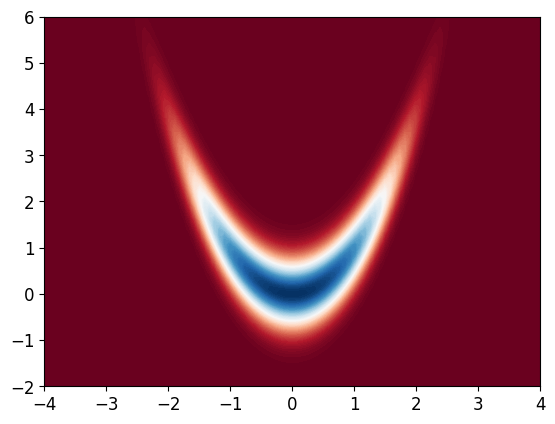

In [25]:
import matplotlib.pyplot as plt

def Pi(x): # implementing the unnormalised density just for visualisation!
    return np.exp(-x[0]**2/10 - x[1]**2/10 - 2 * (x[1] - x[0]**2)**2)

def logPi(x):
    return - x[0]**2/10 - x[1]**2/10 - 2 * (x[1] - x[0]**2)**2

# we will only use log-density for the computations
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = Pi([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.show()

We are interested in estimating the mean of this density, i.e. compute $ \int x \; \pi(x) dx $

We will do  using a Gaussian propsoal $ q(x) = \mathcal{N}(x; 0, \sigma_{\text{IS}}^2) $

Note the SNIS estimator is biased, but consistent (assymptotically unbiased)

In practice, to avoid numerical instability, we do
- Fix $N, \sigma_{IS}$
- Sample $(X_1, \dots X_N) \sim \mathcal{N}(0, \sigma_{\text{IS}}^2)$.
- Compute unnormalised log weights 

$$
\log W^{(i)} = \log \pi(X_{i}) - \log q(X_{i})
$$

- Remove most extreme likelihood

$$
\log W_i = \log W_i - \max_j \log W_j
$$

&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;
Equivalent to setting all weights as a ratio of the largest weight:

$$
W_i = W_i / \max_j W_j
$$

- Normalize weights (log-sum-exp)

$$ 
w_i = \frac{e^{\log W_i}}{\sum_{j=1}^{N} e^{\log W_i}} = \frac{W_i}{\sum_{j=1}^{N} W_j}
$$, 

In [34]:
sig_     = 5 # standard deviation of the proposal

def logq(x, sig): # log-density of the proposal
    return - x[0]**2/(2 * sig**2) - x[1]**2/(2 * sig**2) - np.log(2 * np.pi * sig**2)

# Self-normalised importance sampling
def SNIS_banana(N, sig):
    x_samples = rng.normal(0, sig, (N, 2)) # N 2D samples from the proposal
    logw = np.zeros(N) # log-weights
    for i in range(N):
        logw[i] = logPi(x_samples[i, :]) - logq(x_samples[i, :], sig)
    logw = logw - np.max(logw) # to avoid numerical issues (look up this trick)
    w = np.exp(logw)/np.sum(np.exp(logw)) # normalising the weights
    return np.sum(w[:, np.newaxis] * x_samples, axis=0)

N = 100000
phi_SNIS = SNIS_banana(N, sig_  )
print('estimated mean:', phi_SNIS)

estimated mean: [-0.00549162  0.90488818]


### Sampling from Bayesian Posterior

Under a Bayesian setting, let us take our $\pi(x)$ as a prior. 
\begin{align*}
\pi(x) \propto \exp\left(- \frac{x_1^2}{10} - \frac{x_2^2}{10} - 2 (x_2 - x_1^2)^2
\right)
\end{align*}

Assume we have observed $ y = 1$. Let the likelihood be
\begin{align*}
p(y|x) = \mathcal{N}(y; H x, \sigma^2 I),
\end{align*}
where $H = [1, 0]$. 
i.e. Only the first dimension of the state $x$ is observed in the likelihood 

Let $\sigma = 0.01$ (assume we have observed $y$ with a very small variance)

We wish to sample from the posterior
\begin{align*}
\pi(x|y) \propto p(y|x) \pi(x).
\end{align*}

We will still use proposal $q = \mathcal{N}(x; 0, \sigma_0^2 I)$.

So the importance weights:

$$
W_i = \frac{p(y|X_i) \pi(X_i)}{q(X_i)}
$$


In [28]:
def loglik(y, x, sig):
    H = [1, 0]
    return -(y - H @ x)**2/(2 * sig**2) - np.log(sig * np.sqrt(2 * np.pi))

sig = 0.01 # standard deviation of the likelihood
y = 1 # observation

sig_q = 1 # standard deviation of the proposal

N = 10000
# sample from q
x = rng.normal(0, 1, (2, N)) # 2 x N matrix (2 dimensional, N samples)

# compute logW
logW = np.zeros(N)
for i in range(N):
    logW[i] = (loglik(y, x[:, i], sig)) + logPi(x[:, i]) - logq(x[:, i], sig_q)

logW = logW - np.max(logW)
w = np.exp(logW)/np.sum(np.exp(logW))

mean = np.sum(w * x, axis=1)

print(mean)

[0.99824318 0.99655733]


To measure the performance of a SNIS estimator, one can use the effective sample size (ESS), as a function of the N weights

$$
ESS(N) = \frac{1}{\sum w_i^2}
$$

In [29]:
def ESS(w): # To measure sample quality
    return 1/np.sum(w**2)

print("ESS: ", ESS(w))

ESS:  39.52618998441565


### Resampling

We now have the weighted samples $\{\mathsf{w}_i, X_i\}_{i=1}^N$. 

We want to plot the scatterplot of posterior samples, but we cannot do so with $X_i$, as they are samples from $q$ without the weights. We may wish to have an unweighted sample from the posterior. 

Note with weighted samples, not only can we generate the estimated mean
$\sum w_i X_i$, we can also build an empirical estimate of the target density

$$
\tilde{\pi}^{N}(dx) = \sum_{i=1}^{N} w^{(i)} \delta_{\bar{x}^{(i)}}(dx),
$$

Which is basically the discrete distribution that assigns probability $w_i$ at $X_i$, and 0 otherwise

We can obtain an unweighted sample from the same measure, by sampling i.i.d from $\tilde{\pi}^{N}$,  
i.e., sampling particles $\{ x^{(i)} \}_{i=1}^{N}$ with replacement from $\{\mathsf{w}_i, X_i\}_{i=1}^N$. 
with probabilities $\{ \mathsf{w}_i \}_{i=1}^{N}$.  

This means for $X_i$ that corresponds to high $\mathsf{w}_i$, it will simply be sampled for multiple times (with replacement) from our resample, and would represent a proportion of $\mathsf{w}_i$ in the new sample




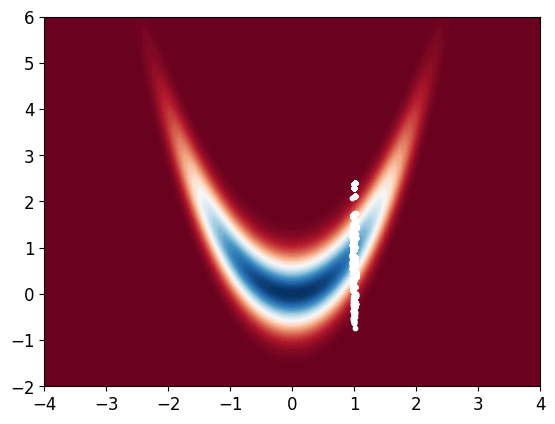

In [30]:
# resample N samples
x_resampled = np.zeros((2, N))
for i in range(N):
    x_resampled[:, i] = x[:, rng.choice(N, p=w)]
    # rng.choice chooses an index from 0 to N-1 with probability w

# now we resampled N samples from this sample set,
# plotting them will give us an approximation of the posterior

# plot resampled samples
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = Pi([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.scatter(x_resampled[0, :], x_resampled[1, :], s=10, c='white')
plt.show()